# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.usetex = True

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import nagisa
import string

# Latent Dirichlet Allocation (LDA)

## SKLearn English Dataset

In [2]:
# Read in the Dataset
n_samples = 1000
data, _ = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'), return_X_y=True,)
data_samples = data[:n_samples]

# take a list of text samples and compute counts over the entire set
# output a vectorized form of the word counts for each document 
# (will be sparse in the many-document case, but is all nonzero for 1 doc)
# vocabulary is a simple dictionary of words and counts
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=0, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)
vocabulary = tf_vectorizer.vocabulary_

# create a list of lists
# where each internal list contains all of the word numbers within
# that document (ex. document 1 contains word 8654)
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [3]:
D = len(docs) #documents
V = len(vocabulary) #vocabulary
T = 20 #topics

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution

In [4]:
z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

In [5]:
# Source: Latent Dirichlet allocation from scratch / Tobias Sterbak: https://www.depends-on-the-definition.com/lda-from-scratch/
for d, doc in enumerate(docs):  
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        #phi_z_w[z][w] += 1
        n_z[z] += 1
        n_d[d] += 1
        
for iteration in range(10):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formula
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1

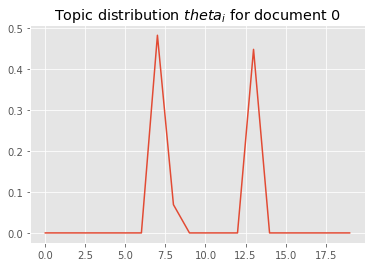

In [6]:
i = 0
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [7]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: 10 hiv 20 12 15 aids 00 health 11 april
Topic #1: car thanks year run use edu computer need drive buy
Topic #2: did don way does game man good current thought years
Topic #3: use drive using good windows ve program better built read
Topic #4: know don think like just left didn parents general new
Topic #5: church space high posting problem nature helmet make normal course
Topic #6: section shall firearm use person license weapon means following business
Topic #7: like just way period heard problem new best got try
Topic #8: people ve don think time like just say way government
Topic #9: key government encryption keys like use public know using chip
Topic #10: food people magi point provide weapons said arab don way
Topic #11: god good just don jesus people like life says make
Topic #12: edu graphics com pub mail send ftp 3d files file
Topic #13: israel jews did just think like said right israeli time
Topic #14: people used men just police know good law want going
Topic #15: d

## Japanese Wikipedia Dataset (with Preprocessing)

In [8]:
wiki_df = pd.read_pickle('wiki') 
wiki_df.head()

,article,views,text
0,メインページ,362562853,ようこそ\nウィキペディア - ウィキペディア日本語版 - 百科事典目次\n検索資料・ポータ...
1,星野源,10190763,星野 源（ほしの みなもと、1981年1月28日 - ）は、日本の音楽家、俳優、文筆家。埼玉...
2,真田信繁,9602104,真田 信繁（さなだ のぶしげ）は、安土桃山時代から江戸時代初期にかけての武将、大名。真田昌幸...
3,高橋一生,8571666,高橋 一生（たかはし いっせい、英字表記：Issey Takahashi、1980年12月9...
4,君の名は。,7788879,『君の名は。』（きみのなは、英: Your Name.）は、2016年に公開された新海誠監督...


In [9]:
stop = ['あそこ',
'あっ',
'あの',
'あのかた',
'あの人',
'あり',
'あります',
'ある',
'あれ',
'い',
'いう',
'います',
'いる',
'う',
'うち',
'え',
'お',
'および',
'おり',
'おります',
'か',
'かつて',
'から',
'が',
'き',
'ここ',
'こちら',
'こと',
'この',
'これ',
'これら',
'さ',
'さらに',
'し',
'しかし',
'する',
'ず',
'せ',
'せる',
'そこ',
'そして',
'その',
'その他',
'その後',
'それ',
'それぞれ',
'それで',
'た',
'ただし',
'たち',
'ため',
'たり',
'だ',
'だっ',
'だれ',
'つ',
'て',
'で',
'でき',
'できる',
'です',
'では',
'でも',
'と',
'という',
'といった',
'とき',
'ところ',
'として',
'とともに',
'とも',
'と共に',
'どこ',
'どの',
'な',
'ない',
'なお',
'なかっ',
'ながら',
'なく',
'なっ',
'など',
'なに',
'なら',
'なり',
'なる',
'なん',
'に',
'において',
'における',
'について',
'にて',
'によって',
'により',
'による',
'に対して',
'に対する',
'に関する',
'の',
'ので',
'のみ',
'は',
'ば',
'へ',
'ほか',
'ほとんど',
'ほど',
'ます',
'また',
'または',
'まで',
'も',
'もの',
'ものの',
'や',
'よう',
'より',
'ら',
'られ',
'られる',
'れ',
'れる',
'を',
'ん',
'何',
'及び',
'彼',
'彼女',
'我々',
'特に',
'私',
'私達',
'貴方',
'貴方方'
'ようこそ',
'ウィキペディア',
'ウィキペディア日本語版',
'百科事典目次',
'検索資料',
'空白',
'補助記号']

In [10]:
data_samples = list(wiki_df['text'])[:100]

In [11]:
# Preprocessing - this section does the following:
# 1. Remove additional stop words identified specific to this dataset
# 2. Use the Nagisa library to split text into words with parts of speech
# 3. Create a new string which uses space delimiters for better algorithm performance
# 4. Append to a list which serves as the new processed dataset
processing_stop = list(string.punctuation) + ['\n','\u3000','Wikipedia','wikipedia','・','FAQ','Main','Page','for','For','non','Japanese','speakers','learners']
new_data_samples = []
for i in range(len(data_samples)): 
    words = nagisa.tagging(data_samples[i])
    new_string = ''
    for w in words.words:
        if w not in processing_stop:
            new_string += (w + ' ')
    new_data_samples.append(new_string)
    #print('finished ' + str(i) + ' of ' + str(len(data_samples)))

In [12]:
new_data_samples[0]

'よう こそ ウィキペディア ウィキペディア 日本 語 版 百 科 事典 目次 検索 資料 ポータル カテゴリ 秀逸 ピックアップ 他 の 秀逸 記事 つまみ 読み 選考 新しい 記事 投票 新着 新しい 画像 投票 新着 今日 は 何 の 日 こよみ 季節 の 話題 季節 の 画像 投票 ガイド 閲覧 方法 参加 方法 引用 方法 ヘルプ ウィキペディア に 関する お 問い合わせ 先 プレスルーム お 知ら せ コミュニティ ポータル 井戸 端 告知 井戸 端 記事 と は アクセス 統計 日本 語 版 の 統計 方針 五 本 の 柱 著作 権 の 扱い 免責 事項 ウィキメディア ウィキメディア の プロジェクト 色々 な メイン ページ 形式 携帯 版 メイン ページ '

In [13]:
tf_vectorizer = CountVectorizer(stop_words=stop,)
tf = tf_vectorizer.fit_transform(new_data_samples) 
vocabulary = tf_vectorizer.vocabulary_

# create a list of lists
# where each internal list contains all of the word numbers within
# that document (ex. document 1 contains word 8654)
docs = []
for row in tf.toarray():
    present_words = np.where(row != 0)[0].tolist()
    present_words_with_count = []
    for word_idx in present_words:
        for count in range(row[word_idx]):
            present_words_with_count.append(word_idx)
    docs.append(present_words_with_count)

In [14]:
vocabulary

{'こそ': 6717,
 '日本': 40750,
 '事典': 24829,
 '目次': 47856,
 '検索': 42822,
 '資料': 55054,
 'ポータル': 21004,
 'カテゴリ': 13058,
 '秀逸': 49049,
 'ピックアップ': 19530,
 '記事': 54126,
 'つまみ': 8280,
 '読み': 54436,
 '選考': 56829,
 '新しい': 40470,
 '投票': 38894,
 '新着': 40563,
 '画像': 47253,
 '今日': 25210,
 'こよみ': 6796,
 '季節': 33610,
 '話題': 54296,
 'ガイド': 13326,
 '閲覧': 57928,
 '方法': 40618,
 '参加': 29479,
 '引用': 36570,
 'ヘルプ': 20484,
 '関する': 57882,
 '問い合わせ': 31043,
 'プレスルーム': 20330,
 '知ら': 48383,
 'コミュニティ': 14524,
 '井戸': 24940,
 '告知': 30703,
 'アクセス': 11027,
 '統計': 50417,
 '方針': 40626,
 '著作': 52657,
 '扱い': 38788,
 '免責': 26980,
 '事項': 24848,
 'ウィキメディア': 12016,
 'プロジェクト': 20364,
 '色々': 52046,
 'メイン': 21713,
 'ページ': 20677,
 '形式': 36802,
 '携帯': 39746,
 '星野': 41040,
 'ほしの': 9683,
 'みな': 10061,
 'もと': 10271,
 '音楽': 58923,
 '俳優': 26414,
 '文筆': 40348,
 '埼玉': 31888,
 '生まれ': 46903,
 '川口': 35444,
 '育ち': 51436,
 'インストゥルメンタル': 11899,
 'バンド': 18991,
 'sakerock': 3680,
 '解散': 53958,
 'リーダー': 22721,
 '主に': 24517,
 'ギター': 13742,
 'マリンバ': 

In [15]:
D = len(docs) #documents
V = len(vocabulary) #vocabulary
T = 20 #topics

alpha = 1 / T         # the parameter of the Dirichlet prior on the per-document topic distributions
beta = 1 / T        # the parameter of the Dirichlet prior on the per-topic word distribution

z_d_n = [[0 for _ in range(len(d))] for d in docs]  # z_i_j
theta_d_z = np.zeros((D, T))
phi_z_w = np.zeros((T, V))
n_d = np.zeros((D))
n_z = np.zeros((T))

In [16]:
# Source: Latent Dirichlet allocation from scratch / Tobias Sterbak: https://www.depends-on-the-definition.com/lda-from-scratch/
for d, doc in enumerate(docs):  
    # n: id of word inside document, w: id of the word globally
    for n, w in enumerate(doc):
        # assign a topic randomly to words
        z_d_n[d][n] = n % T
        # get the topic for word n in document m
        z = z_d_n[d][n]
        # keep track of our counts
        theta_d_z[d][z] += 1
        phi_z_w[z, w] += 1
        #phi_z_w[z][w] += 1
        n_z[z] += 1
        n_d[d] += 1
        
for iteration in range(10):
    for d, doc in enumerate(docs):
        for n, w in enumerate(doc):
            # get the topic for word n in document m
            z = z_d_n[d][n]

            # decrement counts for word w with associated topic z
            theta_d_z[d][z] -= 1
            phi_z_w[z, w] -= 1
            n_z[z] -= 1

            # sample new topic from a multinomial according to our formula
            p_d_t = (theta_d_z[d] + alpha) / (n_d[d] - 1 + T * alpha)
            p_t_w = (phi_z_w[:, w] + beta) / (n_z + V * beta)
            p_z = p_d_t * p_t_w
            p_z /= np.sum(p_z)
            new_z = np.random.multinomial(1, p_z).argmax()

            # set z as the new topic and increment counts
            z_d_n[d][n] = new_z
            theta_d_z[d][new_z] += 1
            phi_z_w[new_z, w] += 1
            n_z[new_z] += 1

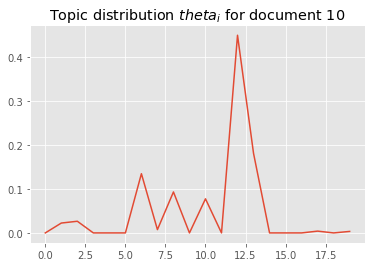

In [17]:
i = 10
plt.plot(theta_d_z[i]/ sum(theta_d_z[i]));
plt.title("Topic distribution $theta_i$ for document {}".format(i));

In [18]:
inv_vocabulary = {v: k for k, v in vocabulary.items()}
n_top_words = 10
for topic_idx, topic in enumerate(phi_z_w):
    message = "Topic #%d: " % topic_idx
    message += " ".join([inv_vocabulary[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    print(message)

Topic #0: 信長 家康 秀吉 徳川 真田 豊臣 信繁 織田 昌幸 大坂
Topic #1: 世界 丑嶋 行っ 回転 聖騎 ハイセ 理由 受け 生活 よっ
Topic #2: よる 天下 女性 文豪 記者 行っ 報告 自由 結果 isbn
Topic #3: 西郷 トランプ アメリカ 問題 大統領 日本 世界 中国 戦争 米国
Topic #4: 日本 地震 安倍 つい よる 経済 地方 震災 被害 内閣
Topic #5: よる ガンダム チーム 発生 鉄華 参加 大型 以降 編集 フレーム
Topic #6: 選手 連続 日本 乃木坂 出場 メジャー 1日 シーズン 試合 熊本
Topic #7: 探偵 コナン 事件 原作 アニメ 登場 キャラクター 作品 能力 異能
Topic #8: 戦車 発売 isbn さん 登場 学園 アニメ おそ松 劇場 大洗
Topic #9: 喰種 捜査 カネキ 襲撃 交戦 赫子 戦闘 re 自身 作戦
Topic #10: 高校 cm 身長 番号 ジャンプ バレー 日向 学校 烏野 予選
Topic #11: 巨人 世界 よっ 調査 人類 フェストゥム 存在 ファフナー システム 開発
Topic #12: テレビ ドラマ 主演 映画 フジ nhk 1日 tbs 女優 日本
Topic #13: 日本 テレビ 出演 東京 開催 アルバム シングル 記録 メンバー 1日
Topic #14: 魔法 相手 自分 登場 カズマ ライン 人間 存在 オン 物語
Topic #15: よっ 自ら 少年 しまう 使い 最終 試験 戦い 仲間 性格
Topic #16: 事故 自分 救命 投稿 ヘリ season twitter ユーザー ドクター 病院
Topic #17: 地球 可能 登場 よる ゲーム 戦闘 ソードアート 保護 しよう サイト
Topic #18: 記録 ナルト 安打 イチロー スバル サスケ 自分 リーグ 一族 投手
Topic #19: 個性 ヒーロー 発売 アニメ fate isbn 魔力 士郎 魔術 限定


In [19]:
data_samples[10]

"さ\n新垣 結衣（あらがき ゆい、1988年6月11日 - ）は、日本の女優、歌手、ファッションモデル。主な愛称はガッキー。沖縄県出身。レプロエンタテインメント所属。\n\n\n== 略歴 ==\n2001年、女子小中学生向けファッション誌『ニコラ』（新潮社）の読者であった姉に「私は（年齢的に）もうできないから」と推されてモデル（ニコモ）オーディションに応募し、グランプリを獲得。2005年春ニコモを卒業するまでに『ニコラ』の表紙モデルとして当時最多となる15回登場している。\nその後、『ニコラ』の卒業を控えた2004年ごろからグラビアや女優業に進出。\nグラビアアイドルとしては、主に少年誌の雑誌グラビアで活動を開始。2006年3月3日に初の写真集『ちゅら☆ちゅら』を、5月17日にイメージビデオ『XIANGYU シャンユイ〜相偶』を発表した。\nバラエティ番組では、2005年10月から『落下女』（日本テレビ）にレギュラーとして出演。\n2006年から2008年にかけて江崎グリコ「ポッキー」シリーズのCMに出演、このCMがきっかけとなりブレイクを果たした。\n女優としては、2005年に『Sh15uya』（シブヤフィフティーン）（テレビ朝日）でドラマデビュー。2006年1月、『トゥルーラブ』（フジテレビ）でドラマ初主演。4月期・7月期はそれぞれ、土9ドラマ『ギャルサー』と『マイ☆ボス マイ☆ヒーロー』（ともに日本テレビ）へ2クール連続で出演。\nアニメの声優にも挑戦し、映画『超劇場版ケロロ軍曹』ではミララ役でゲスト出演、テレビアニメ『デジモンセイバーズ』（フジテレビ）では、藤枝淑乃役でレギュラー出演した。\n映画『ワルボロ』（2007年9月8日公開）で映画初出演。『恋するマドリ』（2007年8月18日公開）で映画初主演。その後も『恋空』や『ハナミズキ』で主演を務めた。\n2007年8月6日、『恋するマドリ』の主題歌「メモリーズ」で、歌手デビュー。同曲は「SCHOOL OF LOCK!」のサイトでの独占先行配信で、着うたのみ同日から4日間先行配信された。さらに10月1日には、『恋空』の挿入歌「heavenly days」が「GIRLS LOCKS!」にてほとんどフル（2サビの頭まで）で披露された。その後も、本人出演時を中心に「SCHOOL OF LOCK!」で新曲が披露さ

# Non-Negative Matrix Factorization (NMF)

## 20 Topics

In [20]:
# Import the needed module
from sklearn.decomposition import NMF

In [21]:
# Initialize the model
model = NMF(n_components=20, random_state=0, l1_ratio=.5, verbose=1)

In [22]:
# Fit the model
model.fit(tf)

C:\Users\Marisa\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


violation: 1.0
violation: 0.37204907863104697
violation: 0.18082658314602498
violation: 0.09590971321355135
violation: 0.0559285852440448
violation: 0.034980840387747375
violation: 0.020916300955783163
violation: 0.012651068258961866
violation: 0.007418244596004021
violation: 0.0046253837141783695
violation: 0.0026351832938425004
violation: 0.0016085629565914525
violation: 0.0011566128055914334
violation: 0.0008604826887663018
violation: 0.0006512259549851942
violation: 0.0005053959985147539
violation: 0.0003977072180626683
violation: 0.0003168315072402853
violation: 0.0002541127054445398
violation: 0.00020520759324096953
violation: 0.00016661349679855016
violation: 0.00013624937702920074
violation: 0.0001123187408448753
violation: 9.323422337924629e-05
Converged at iteration 25


NMF(l1_ratio=0.5, n_components=20, random_state=0, verbose=1)

In [23]:
# Extract the top 10 terms per topic for all 20 topics
tf_feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(model.components_):
    print("Topic #" + str(topic_idx) + ": " + 
          str(['{}'.format(tf_feature_names[i]) for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0: ['日本', '世界', '経済', 'アメリカ', '関係', 'よる', '中国', '問題', '政府', '現在']
Topic #1: ['喰種', '捜査', 'カネキ', '赫子', 'クインケ', 'アオギリ', 're', '作戦', '月山', 'ccg']
Topic #2: ['戦車', '学園', '大洗', 'チーム', '高校', '試合', 'みほ', '女子', '劇場', '隊長']
Topic #3: ['fate', '士郎', 'アニメ', 'セイバー', '聖杯', '魔術', 'サーヴァント', 'stay', 'night', '宝具']
Topic #4: ['巨人', 'エレン', '兵団', '調査', '進撃', 'ウォール', 'マーレ', '発売', '人間', 'isbn']
Topic #5: ['家康', '秀吉', '真田', '徳川', '信繁', '豊臣', '大坂', '昌幸', '三成', '家臣']
Topic #6: ['高校', 'cm', '身長', '烏野', 'バレー', '日向', '番号', '春高', '体重', 'kg']
Topic #7: ['個性', 'ヒーロー', '出久', 'オールマイト', '自身', 'ヴィラン', '好き', '雄英', 'cm', '身長']
Topic #8: ['ナルト', 'サスケ', 'よっ', '大戦', '忍界', '自分', '一族', 'カカシ', '転生', '大蛇']
Topic #9: ['記録', '安打', 'イチロー', 'シーズン', '連続', 'リーグ', 'メジャー', '試合', '日本', '選手']
Topic #10: ['地震', '熊本', '震災', '被害', '発生', '災害', '被災', '避難', '日本', '福島']
Topic #11: ['鉄華', 'ガンダム', 'マクギリス', '地球', 'ms', '機体', '武装', 'フレーム', 'ギャラル', 'ホルン']
Topic #12: ['魔法', 'カズマ', 'アクア', '冒険', 'めぐみん', '世界', 'スキル', '魔王', 'モンスター', 'アニメ']
Topic #

In [24]:
# Extract the topic features for every document in the dataset
nmf_features = model.transform(tf)

violation: 1.0
violation: 0.5235132723613904
violation: 0.060849560679105415
violation: 0.01494005235956189
violation: 0.006283186716783035
violation: 0.0023143470917197867
violation: 0.0008145417194338431
violation: 0.0003522511321089529
violation: 0.00016550179729120555
violation: 6.019612129260751e-05
Converged at iteration 11


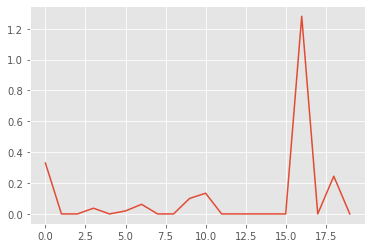

In [25]:
# Plot the weights of each topic for document 10 
plt.plot(pd.DataFrame(nmf_features).loc[10])
plt.show()

## 17 Topics

In [26]:
# Initialize the model
model = NMF(n_components=17, random_state=0, l1_ratio=.5, verbose=1)

# Fit the model
model.fit(tf)

C:\Users\Marisa\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


violation: 1.0
violation: 0.3905397920776066
violation: 0.1973608133265016
violation: 0.1086443998603953
violation: 0.06704431095692587
violation: 0.04294840758651551
violation: 0.026644214929027948
violation: 0.016682826913001467
violation: 0.011035837474052481
violation: 0.007647788683595485
violation: 0.005109292360600282
violation: 0.0035786091478825772
violation: 0.002720327488487924
violation: 0.0020674443910897325
violation: 0.0015953387286487244
violation: 0.001245118711914335
violation: 0.0009779485452409487
violation: 0.0007750064527184222
violation: 0.0006184720018600212
violation: 0.0004941419780971664
violation: 0.00039559407220747604
violation: 0.00031831498716841005
violation: 0.0002576352662433078
violation: 0.00020981172870612527
violation: 0.00017216117504803872
violation: 0.00014026603521066425
violation: 0.00011540259329310101
violation: 9.632723435241803e-05
Converged at iteration 29


NMF(l1_ratio=0.5, n_components=17, random_state=0, verbose=1)

In [27]:
# Extract the top 10 terms per topic for all 20 topics
tf_feature_names = tf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(model.components_):
    print("Topic #" + str(topic_idx) + ": " + 
          str(['{}'.format(tf_feature_names[i]) for i in topic.argsort()[:-10 - 1:-1]]))

Topic #0: ['日本', '世界', '経済', 'アメリカ', '関係', 'よる', '中国', '問題', '政府', '現在']
Topic #1: ['喰種', '捜査', 'カネキ', '赫子', 'クインケ', 'アオギリ', 're', '作戦', '月山', 'ccg']
Topic #2: ['戦車', '学園', '大洗', 'チーム', '高校', '試合', 'みほ', '女子', '劇場', '隊長']
Topic #3: ['fate', '士郎', 'アニメ', 'セイバー', '魔術', '聖杯', 'サーヴァント', 'stay', 'night', '発売']
Topic #4: ['巨人', 'エレン', '兵団', '調査', '進撃', 'ウォール', 'マーレ', '発売', '人間', 'isbn']
Topic #5: ['家康', '秀吉', '真田', '徳川', '信繁', '豊臣', '大坂', '昌幸', '三成', '家臣']
Topic #6: ['高校', 'cm', '身長', '烏野', 'バレー', '日向', '番号', '春高', '体重', 'kg']
Topic #7: ['個性', 'ヒーロー', '出久', 'オールマイト', '自身', 'ヴィラン', '好き', '雄英', 'cm', '身長']
Topic #8: ['ナルト', 'サスケ', 'よっ', '大戦', '忍界', '自分', '一族', 'カカシ', '転生', '大蛇']
Topic #9: ['記録', '安打', 'イチロー', 'シーズン', '連続', 'リーグ', 'メジャー', '試合', '日本', '選手']
Topic #10: ['地震', '熊本', '震災', '被害', '災害', '発生', '被災', '避難', 'よる', '福島']
Topic #11: ['鉄華', 'ガンダム', 'マクギリス', '地球', 'ms', '機体', '武装', 'フレーム', 'ギャラル', 'ホルン']
Topic #12: ['魔法', 'カズマ', '冒険', 'アクア', 'めぐみん', '世界', 'スキル', '魔力', '魔王', 'モンスター']
Topic #1

In [28]:
# Extract the topic features for every document in the dataset
nmf_features = model.transform(tf)

violation: 1.0
violation: 0.5030464518502473
violation: 0.060142896950857665
violation: 0.01527580444841924
violation: 0.006039558290426714
violation: 0.0017599250702538909
violation: 0.0005751881662196545
violation: 0.00025144311186186397
violation: 8.943855028445706e-05
Converged at iteration 10


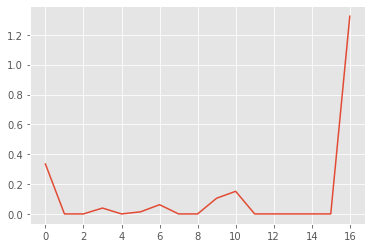

In [29]:
# Plot the weights of each topic for document 10 
plt.plot(pd.DataFrame(nmf_features).loc[10])
plt.show()